# Reverse Padding Function

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def reverse_padding(padded_sequences, padding_value=-1):
    mask = (padded_sequences != padding_value)
    unpadded_sequences = [seq[mask[i]] for i, seq in enumerate(padded_sequences)]
    return unpadded_sequences

# Reading the Data

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences


import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)


import random

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res


# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed



def get_filepaths(mainfolder):
    """
    Searches a folder for all unique files and compile a dictionary of their paths.

    Parameters
    --------------

    mainfolder: the filepath for the folder containing the data

    Returns
    --------------

    training_filepaths: file paths to be used for training
    testing_filepaths:  file paths to be used for testing
    """
    training_filepaths = {}
    testing_filepaths  = {}
    folders = os.listdir(mainfolder)
    for folder in folders:
        fpath = mainfolder + "/" + folder
        if os.path.isdir(fpath):
            filenames = os.listdir(fpath)
            for filename in filenames[:int(round(0.9*len(filenames)))]:
                fullpath = fpath + "/" + filename
                training_filepaths[fullpath] = folder
            for filename1 in filenames[int(round(0.9*len(filenames))):]:
                fullpath1 = fpath + "/" + filename1
                testing_filepaths[fullpath1] = folder
    return training_filepaths, testing_filepaths

def get_labels(mainfolder):
    """ Creates a dictionary of labels for each unique type of motion """
    labels = {}
    label = 0
    for folder in os.listdir(mainfolder):
        fpath = mainfolder + "/" + folder
        if os.path.isdir(fpath):
            labels[folder] = label
            label += 1
    return labels

def get_data(fp, labels, folders, norm, std, center):
    """
    Creates a dataframe for the data in the filepath and creates a one-hot
    encoding of the file's label
    """
    data = pd.read_csv(filepath_or_buffer=fp,sep= ",",skiprows=1 ,names = ["time", "ax", "ay", "az","wx", "wy", "wz"])
    #values = data[:,0].split('\t')
    # padded_data = pad_sequences(data.iloc[:, 1:], padding = 'post',value=-1, dtype=object)
    # if norm and not std:
    #     normed_data = norm_data(data.iloc[:, 1:])  # This selects all rows and all columns starting from the second column

    # elif std and not norm:
    #     stdized_data = standardize(data.iloc[:, 1:])
    # elif center and not norm and not std:
    #     cent_data = subtract_mean(data.iloc[:, 1:])

    one_hot = np.zeros(len(labels))
    file_dir = folders[fp]
    label = labels[file_dir]
    one_hot[label] = 1
    # Split the timestamp string based on the dot (.)
    elapsed_times = []
    timestamp_str_column = data['time'] 
    for time in timestamp_str_column:
        time_part = str(time).split()[-1].split(':')[-1]
        elapsed_times.append(time_part)
    data['time'] = elapsed_times
    return data, one_hot, label


import pandas as pd
import random

# def calculate_sampling_rate(df, file_name):
#     # Extract timestamps and convert them to float
#     df['time'] = df['time'].astype(str).str.split('.').str[0]  # Remove milliseconds
#     timestamps = df['time'].astype(float)
    
#     # Find the minimum and maximum timestamps
#     min_timestamp = timestamps.min()
#     max_timestamp = timestamps.max()

#     retries = 0
#     while retries < 10:  # Limit retries to avoid infinite loops
#         # Generate a random target second between min and max timestamps
#         target_second = int(random.uniform(min_timestamp + 1, max_timestamp - 1))

#         # Calculate the corresponding next second
#         next_second = target_second + 1 if target_second < 59 else 0

#         # Check if both target_second and next_second are present in the timestamps
#         if target_second in timestamps.values and next_second in timestamps.values:
#             # Find the index of the target second
#             target_index = (timestamps >= target_second).idxmax()

#             # Find the index of the next second
#             next_second_index = (timestamps >= next_second).idxmax()

#             # Calculate samples count
#             samples_count = next_second_index - target_index + 1

#             if samples_count >= 100:
#                 print("Random second:", target_second)
#                 print("Sampling Rate:", samples_count, "File name:", file_name)
#                 return samples_count
        
#         retries += 1
    
#     print("Could not find valid sampling rate after 10 retries and file name is ", file_name , "random number is ", target_second)
#     return None  # Or handle this case according to your needs


# Define the function calculate_sampling_rate
def calculate_sampling_rate(df, file_name):

    # Extract timestamps and convert them to float
    df['time'] = df['time'].astype(str).str.split('.').str[0]  # Remove milliseconds
    timestamps = df['time'].astype(float)
    
    # Find the minimum and maximum timestamps
    min_timestamp = timestamps.min()
    max_timestamp = timestamps.max()

    retries = 0
    while retries < 100:  # Limit retries to avoid infinite loops
        # Generate a random target second between min and max timestamps
        target_second = int(random.uniform(min_timestamp + 1, max_timestamp - 1))

        # Ensure target_second is not 59
        if target_second != 59:
            # Calculate the corresponding next second
            next_second = target_second + 1 

            # Check if both target_second and next_second are present in the timestamps
            if target_second in timestamps.values and next_second in timestamps.values:
                # Find the index of the target second
                target_index = np.where(timestamps == target_second)[0][0]

                # Find the index of the next second
                next_second_index = np.where(timestamps == next_second)[0][0]

                # Calculate samples count
                samples_count = next_second_index - target_index + 1
                
                # Check if samples_count is at least 100
                if samples_count >= 100:
                    # print("Sampling Rate:", samples_count, "File name: ", file_name)
                    return samples_count
        
        retries += 1
    
    print("Could not find valid sampling rate (>= 100) after 100 retries and file name is ", file_name)
    return None  # Or handle this case according to your needs





# Normalizes the data by removing the mean

def subtract_mean(input_data):
    # Subtract the mean along each column
    centered_data = input_data - input_data.mean()
    
    return centered_data


def norm_data(data):
    """
    Normalizes the data.
    For normalizing each entry, y = (x - min)/(max - min)
    """
    c_data = subtract_mean(data)
    mms = MinMaxScaler()
    mms.fit(c_data)
    n_data = mms.transform(c_data)
    return n_data

def standardize(data):
    c_data = subtract_mean(data)
    std_data = c_data/ pd.std(c_data)
    return std_data

def pad_sequences1(normed):
    padded_sequences = pad_sequences(normed, padding='post', dtype=object, value=float('-inf'))
    return padded_sequences



def vectorize(data,window_size):
    sequences = [data[i:i+window_size] for i in range(len(data)-window_size)]
    shuffle(sequences)
    sequences = np.array(sequences)
    return sequences

# def build_inputs(files_list, accel_labels, file_label_dict, norm_bool, std_bool, center_bool, window_size=50):
#     X_seq = []
#     y_seq = []
#     labels = []
#     min_sampling_rate = float('inf')  # Initialize with a very large value
    
#     max_length = 0  # Track the maximum sequence length
    
#     for path in files_list:
#         normed_data, target, target_label = get_data(path, accel_labels, file_label_dict, norm_bool, std_bool, center_bool)
        
#         # Calculate sampling rate
#         sampling_rate = calculate_sampling_rate(normed_data, file_name=os.path.basename(path))
        
#         # Track minimum sampling rate
#         min_sampling_rate = min(min_sampling_rate, sampling_rate)

#         input_list = normed_data.values 
#         X_seq.append(input_list)
#         max_length = max(max_length, len(input_list))
#         y_seq.append(list(target)) 
#         labels.append(target_label)  

#     # Downsample all files to minimum sampling rate
#     downsampled_X = []
#     for seq in X_seq:
#         downsampled_seq = seq[::min_sampling_rate]  # Downsample by taking every nth sample
#         downsampled_X.append(downsampled_seq)
    
#     X_padded = pad_sequences1(downsampled_X)
#     X_padded = np.array(X_padded)
#     X_padded = X_padded.reshape(-1, max_length, X_padded.shape[2])

#     y_padded = np.array(y_seq)

#     return X_padded, y_padded, labels, min_sampling_rate

from scipy.signal import resample

def build_inputs(files_list, accel_labels, file_label_dict, norm_bool, std_bool, center_bool, window_size=50):
    X_seq = []
    y_seq = []
    labels = []
    downsample = 0
    no_downsample = 0
    min_sampling_rate = float('inf')  # Initialize with a very large value
    
    max_length_before_padding = 0  # Track the maximum sequence length before padding
    
    for path in files_list:
        normed_data, target, target_label = get_data(path, accel_labels, file_label_dict, norm_bool, std_bool, center_bool)
        
        # Calculate sampling rate
        sampling_rate = calculate_sampling_rate(normed_data, file_name=os.path.basename(path))
        
        # Track minimum sampling rate
        min_sampling_rate = min(min_sampling_rate, sampling_rate)

        if (sampling_rate - 50 )  > min_sampling_rate:  # Check if sampling rate is greater than minimum
            downsample_factor = int(sampling_rate / min_sampling_rate)
            downsampled_seq = resample(normed_data.values, len(normed_data) // downsample_factor)  # Downsample using scipy.signal.resample
            downsample = downsample + 1
        else:
            downsampled_seq = normed_data.values  # Keep the original sequence if sampling rate is already at or below minimum
            no_downsample = no_downsample + 1
        # print(len(downsampled_seq))
        X_seq.append(downsampled_seq)
        max_length_before_padding = max(max_length_before_padding, len(downsampled_seq))  # Update maximum length
        
        y_seq.append(list(target)) 
        labels.append(target_label)  

    X_padded = pad_sequences1(X_seq)
    X_padded = np.array(X_padded)
    X_padded = X_padded.reshape(-1, max_length_before_padding, X_padded.shape[2])  # Reshape using maximum length before padding

    y_padded = np.array(y_seq)
    
    print("Min sampling rate:" , min_sampling_rate)
    print("Number of downsampled files:" , downsample)
    print("Number of not downsampled files:" , no_downsample)

    return X_padded, y_padded, labels


if __name__ == '__main__':

    mainpath = "D:/Nour/Semester 8/Graduation Projection/Datasets/Dummy-HAR-Copy1-Copy"
    activity_labels                  = get_labels(mainpath)
    training_dict, testing_dict      = get_filepaths(mainpath)
    training_files                   = list(training_dict.keys())
    testing_files                    = list(testing_dict.keys())

    # build training inputs and labels
    X_train, y_train, train_labels = build_inputs(
        training_files,
        activity_labels,
        training_dict,
        True, False, False)
    # build tesing inputs and labels
    X_test, y_test, test_labels    = build_inputs(
        testing_files,
        activity_labels,
        testing_dict,
        True, False, False)
    

Min sampling rate: 100
Number of downsampled files: 0
Number of not downsampled files: 58
Min sampling rate: 100
Number of downsampled files: 0
Number of not downsampled files: 6


In [124]:
import pandas as pd
from pandas import DataFrame
df = DataFrame(arr, columns=['ax','ay','az','wx','wy','wz'])
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame containing the dataset
# Replace 'df' with the name of your DataFrame

# Define a function to compute summary statistics
def compute_summary_stats(data):
    stats = {
        'count': data.count(),
        'mean': data.mean(),
        'std': data.std(),
        'min': data.min(),
        '25%': data.quantile(0.25),
        '50%': data.median(),
        '75%': data.quantile(0.75),
        'max': data.max()
    }
    return pd.Series(stats)

# Compute summary statistics for each feature
summary_stats = df.apply(compute_summary_stats)

# Convert the dictionary to a DataFrame
summary_stats_df = DataFrame(summary_stats, columns=['ax', 'ay', 'az', 'wx' ,'wy', 'wz'])

# Display the summary statistics DataFrame
print(summary_stats_df)


                  ax             ay             az             wx  \
count  137747.000000  137747.000000  137747.000000  137747.000000   
mean       -0.026707      -0.433598      -0.101134       0.010649   
std         3.368705       4.379308       3.945925       1.964085   
min       -22.600000     -38.140000     -34.330000     -13.680000   
25%        -1.690000      -1.790000      -1.820000      -0.960000   
50%        -0.030000       0.000000      -0.060000      -0.150000   
75%         1.710000       1.250000       1.470000       0.850000   
max        19.830000      20.590000      42.740000      11.330000   

                  wy             wz  
count  137747.000000  137747.000000  
mean        0.024830       0.000430  
std         1.161684       1.142372  
min       -14.330000      -7.610000  
25%        -0.530000      -0.610000  
50%         0.080000      -0.110000  
75%         0.640000       0.630000  
max        10.900000       8.650000  


In [155]:
summary_stats_df

,ax,ay,az,wx,wy,wz
count,137747.000000,137747.000000,137747.000000,137747.000000,137747.000000,137747.000000
mean,-0.026707,-0.433598,-0.101134,0.010649,0.024830,0.000430
std,3.368705,4.379308,3.945925,1.964085,1.161684,1.142372
min,-22.600000,-38.140000,-34.330000,-13.680000,-14.330000,-7.610000
25%,-1.690000,-1.790000,-1.820000,-0.960000,-0.530000,-0.610000
50%,-0.030000,0.000000,-0.060000,-0.150000,0.080000,-0.110000
75%,1.710000,1.250000,1.470000,0.850000,0.640000,0.630000
max,19.830000,20.590000,42.740000,11.330000,10.900000,8.650000


In [117]:
x_train = X_train[:,:,1:]
x = reverse_padding(x_train,float('-inf'))
#without the timestamp
arr = np.array([])
for i in x:
    i = i.reshape(len(i)//6, 6)
    arr = np.append(arr,i)

arr = arr.reshape(len(arr)//6, 6)


# Gyroscope + Accelerometer Plots


In [6]:
class_1_label = 0
class_2_label = 1
class_3_label = 2

class_1_indices = np.where(train_labels == class_1_label)[0]
class_2_indices = np.where(train_labels == class_2_label)[0]
class_3_indices = np.where(train_labels == class_3_label)[0]


class_0_data = X_train[0]
class_1_data = X_train[30]
class_2_data = X_train[50]


In [7]:
class_0_accelerometer = [[float(data[i]) for data in class_0_data] for i in range(1, 4)]
class_0_gyroscope = [[float(data[i]) for data in class_0_data] for i in range(4, 7)]

class_1_accelerometer = [[float(data[i]) for data in class_1_data] for i in range(1, 4)]
class_1_gyroscope = [[float(data[i]) for data in class_1_data] for i in range(4, 7)]

class_2_accelerometer = [[float(data[i]) for data in class_2_data] for i in range(1, 4)]
class_2_gyroscope = [[float(data[i]) for data in class_2_data] for i in range(4, 7)]

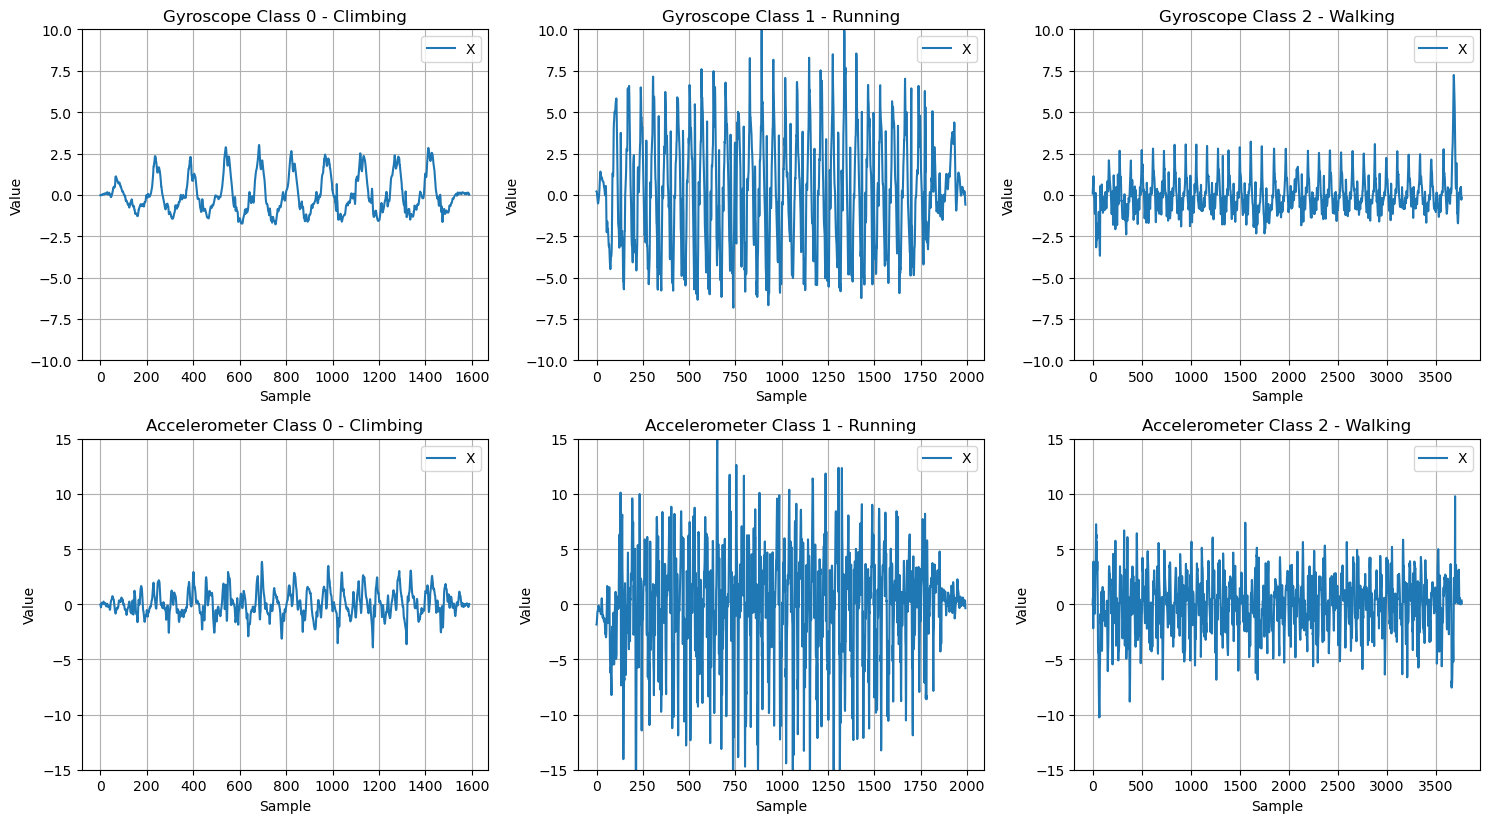

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

# Gyroscope Class 0 - Climbing
plt.subplot(3, 3, 1)
plt.plot(class_0_gyroscope[0], label='X')
plt.title('Gyroscope Class 0 - Climbing')
plt.ylim(-10, 10)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Gyroscope Class 1 - Running
plt.subplot(3, 3, 2)
plt.plot(class_1_gyroscope[0], label='X')
plt.title('Gyroscope Class 1 - Running')
plt.ylim(-10,10)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Gyroscope Class 2 - Walking
plt.subplot(3, 3, 3)
plt.plot(class_2_gyroscope[0], label='X')
plt.title('Gyroscope Class 2 - Walking')
plt.ylim(-10, 10)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Accelerometer Class 0
plt.subplot(3, 3, 4)
plt.plot(class_0_accelerometer[0], label='X')
plt.title('Accelerometer Class 0 - Climbing')
plt.ylim(-15, 15)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Accelerometer Class 1
plt.subplot(3, 3, 5)
plt.plot(class_1_accelerometer[0], label='X')
plt.title('Accelerometer Class 1 - Running')
plt.ylim(-15, 15)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Accelerometer Class 2
plt.subplot(3, 3, 6)
plt.plot(class_2_accelerometer[0], label='X')
plt.title('Accelerometer Class 2 - Walking')
plt.ylim(-15, 15)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Zigzag Algorithm

In [1]:
# Zigzag scan of a matrix
# Argument is a two-dimensional matrix of any size,
# not strictly a square one.
# Function returns a 1-by-(m*n) array,
# where m and n are sizes of an input matrix,
# consisting of its items scanned by a zigzag method.
#
# Matlab Code:
# Alexey S. Sokolov a.k.a. nICKEL, Moscow, Russia
# June 2007
# alex.nickel@gmail.com
import numpy as np

def zigzag(input):
    #initializing the variables
    #----------------------------------
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    vmax = input.shape[0]
    hmax = input.shape[1]
   
    #print(vmax ,hmax)

    i = 0

    output = np.zeros(( vmax * hmax))
    #----------------------------------
    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:   # going up
            if (v == vmin):
                output[i] = input[v, h]   # if we got to the first line
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        
                i = i + 1
            elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last col
                output[i] = input[v, h]
                v = v + 1
                i = i + 1
            elif ((v > vmin) and (h < hmax -1 )):    # all other case
                output[i] = input[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:                                    # going down
            if ((v == vmax -1) and (h <= hmax -1)):       # if we got to
                output[i] = input[v, h]
                h = h + 1
                i = i + 1
            elif (h == hmin):                  # if we got to the first colum          
                output[i] = input[v, h]
                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1
                    i = i + 1
            elif ((v < vmax -1) and (h > hmin)):     # all other cases       
                output[i] = input[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if ((v == vmax-1) and (h == hmax-1)):  
            output[i] = input[v, h]
            break
    
    return output




# Inverse zigzag scan of a matrix
# Arguments are: a 1-by-m*n array,
# where m & n are vertical & horizontal sizes of an output matrix.
# Function returns a two-dimensional matrix of defined sizes,
# consisting of input array items gathered by a zigzag method.
#
# Matlab Code:
# Alexey S. Sokolov a.k.a. nICKEL, Moscow, Russia
# June 2007
# alex.nickel@gmail.com


def inverse_zigzag(input, vmax, hmax):
    h = 0
    v = 0

    vmin = 0
    hmin = 0
    
    output = np.zeros((vmax, hmax))
    
    i = 0
    #---------------------------------
    
    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:                 # going up
            if (v == vmin):
                output[v, h] = input[i]        # if we got to the first line
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        
                    i = i + 1
            elif ((h == hmax -1 ) and (v < vmax)): 
                output[v, h] = input[i]
                v = v + 1
                i = i + 1
            elif ((v > vmin) and (h < hmax -1 )):
                output[v, h] = input[i]
                v = v - 1
                h = h + 1
                i = i + 1
        else:                                    # going down
            if ((v == vmax -1) and (h <= hmax -1)):   
                output[v, h] = input[i]
                h = h + 1
                i = i + 1
            elif (h == hmin):
                output[v, h] = input[i]
                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1
                    i = i + 1
            elif((v < vmax -1) and (h > hmin)):
                output[v, h] = input[i]
                v = v + 1
                h = h - 1
                i = i + 1
        if ((v == vmax-1) and (h == hmax-1)): 
            output[v, h] = input[i]
            break
    return output

In [ ]:
import numpy as np
true_labels = np.repeat((0,1,2),10)  
print(true_labels)

points_per_class = 10
selected_indices = []

for class_label in np.unique(true_labels):
    indices_for_class = np.where(train_labels == class_label)[0]

    selected_indices.extend(indices_for_class[:points_per_class])

In [ ]:
selected_series = np.array([])

for index in selected_indices:
    selected_series = np.append(X_train[index], selected_series)


In [ ]:
selected_series = selected_series.reshape(30, 6262, 7)

In [7]:
selected_series

array([[['33', 0.18, 0.27, ..., -0.01, 0.14, 0.1],
        ['33', 0.24, 0.23, ..., 0.0, 0.18, 0.11],
        ['33', 0.39, 0.3, ..., 0.0, 0.18, 0.11],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],

       [['09', 1.59, 0.38, ..., -0.05, 0.16, -0.45],
        ['09', 1.68, 0.42, ..., -0.13, 0.12, -0.48],
        ['09', 1.83, 0.28, ..., -0.16, 0.08, -0.5],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],

       [['56', -1.14, -0.36, ..., 0.19, 0.14, 1.12],
        ['12', -1.37, -0.65, ..., 0.4, 0.14, 1.12],
        ['12', -1.2, -0.68, ..., 0.56, 0.08, 1.12],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],

       ...,

       [['28', -0.

# Testing Different Durations

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle
from simpsom import SOMNet

seconds = [200, 500, 800, 1000, 1200, 1500]


silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []


clustering_methods = {
    "KMeans": KMeans(n_clusters=10),
    "Birch": Birch(n_clusters=10, threshold=0.5),
    "SOM": SOMNet(10, 10, X, metric='euclidean')
}
for second in seconds:
    print(f"\n--- Duration: {second} seconds ---")
    x_train = selected_series[:,:second,1:]
    x = reverse_padding(x_train,float('-inf'))
    #without the timestamp
    arr = np.array([])
    for i in x:
        i = i.reshape(second, 6)
        arr = np.append(arr,i)

    arr = arr.reshape(30*second, 6)
    matched_labels = np.repeat(true_labels, second)
    for method_name,method in clustering_methods.items():
        print(f"\nClustering Method: {method_name}")

        if method_name == "SOM":
            net = SOMNet(10, 10, arr, metric='euclidean')
            net.train(train_algo='online', start_learning_rate=0.01, batch_size=-1, early_stop=None)
            labels, _ = net.cluster(arr, algorithm='KMeans', n_clusters= 3)
        else:
            method.fit(arr)
            labels = method.labels_


        silhouette = silhouette_score(arr,labels)
        davies_bouldin = davies_bouldin_score(arr,labels)
        ch = calinski_harabasz_score(arr,labels)
        v_measure = v_measure_score(matched_labels, labels)

        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)
        calinski_harabasz_scores.append(ch)
        v_measure_scores.append(v_measure)

        print("Silhouette Score:", silhouette)
        print("Davies Bouldin Index:", davies_bouldin)
        print("Calinski Harabsz Index:", ch)
        print("V Measure:", v_measure)




In [55]:
seconds1 = [200, 500, 800, 1000, 1200, 1500]
scores = pd.DataFrame( columns=['Duration(s)','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for i in seconds1:
    for j in clustering_methods:
        scores.loc[k] = [i, j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
        k += 1

scores

,Duration(s),Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,200,KMeans,0.449985,1.268668,1615.197966,0.115546
1,200,Birch,0.427036,1.306899,1360.920253,0.130152
2,500,KMeans,0.430953,1.205182,4902.249284,0.222915
3,500,Birch,0.324947,1.505505,3291.539708,0.176065
4,800,KMeans,0.414689,1.208772,7924.217680,0.242041
5,800,Birch,0.319338,1.485954,5777.218531,0.202056
6,1000,KMeans,0.410755,1.199710,10121.646304,0.250575
7,1000,Birch,0.364280,1.377978,7631.752718,0.219461
8,1200,KMeans,0.407311,1.197557,12312.867645,0.257454
9,1200,Birch,0.329518,1.553984,8748.320281,0.252051


# Feature Extraction

In [11]:
x_train = X_train[:, 200:1500, 1:]
x = reverse_padding(x_train,float('-inf'))
arr = np.array([])
for i in x:
    arr = np.append(arr,i)
arr = arr.reshape(58, 1300, 6)

In [12]:
arr = list(arr)

In [13]:
import tsfel

cfg1 = tsfel.get_features_by_domain()

ext2 = tsfel.time_series_features_extractor(cfg1, arr, fs= 100)

*** Feature extraction started ***



*** Feature extraction finished ***


In [14]:
from sklearn.feature_selection import VarianceThreshold
import tsfel

corr_features = tsfel.correlated_features(ext2)
ext2.drop(corr_features, axis=1, inplace=True)

selector = VarianceThreshold()
ext2 = selector.fit_transform(ext2)


In [15]:
cfg1 = tsfel.get_features_by_domain('temporal')

ext3 = tsfel.time_series_features_extractor(cfg1, arr, fs= 100)

*** Feature extraction started ***



*** Feature extraction finished ***


In [16]:
cfg1 = tsfel.get_features_by_domain('spectral')

ext4 = tsfel.time_series_features_extractor(cfg1, arr, fs= 100)

*** Feature extraction started ***



*** Feature extraction finished ***


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score ,adjusted_rand_score, fowlkes_mallows_score, v_measure_score
from sklearn.cluster import KMeans, Birch, DBSCAN, AgglomerativeClustering

feat = [ext2, ext3, ext4]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = {
    "KMeans": KMeans(n_clusters=3, random_state=0),
    "Birch": Birch(n_clusters=3, threshold=0.5),
}

for f in feat:
    for method_name, method in clustering_methods.items():
        print(f"Clustering Method: {method_name}")
        

        method.fit(f)
        labels = method.labels_

        # Calculate evaluation metrics
        sil = silhouette_score(ext2, labels)
        davies_bouldin_score_value = davies_bouldin_score(ext2, labels)
        ch = calinski_harabasz_score(ext2, labels)
        v_measure = v_measure_score(train_labels, labels)

        silhouette_scores.append(sil)
        davies_bouldin_scores.append(davies_bouldin_score_value)
        calinski_harabasz_scores.append(ch)
        v_measure_scores.append(v_measure)

   
        print("Silhouette Score: ", sil)
        print("Davies Bouldin Score: ", davies_bouldin_score_value)
        print("Calinski:", ch)
        print("V-Measure: ", v_measure)


In [18]:
feature = ['All Features', 'Temporal', 'Spectral']
scores = pd.DataFrame( columns=['Feature Extraction','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for i in feature:
    for j in clustering_methods:
        scores.loc[k] = [i, j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
        k += 1

scores

,Feature Extraction,Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,All Features,KMeans,0.642800,0.486101,247.378192,0.562436
1,All Features,Birch,0.629654,0.493406,231.624038,0.543242
2,Temporal,KMeans,0.494339,0.944496,81.169488,0.615438
3,Temporal,Birch,0.457557,0.812150,83.105226,0.615438
4,Spectral,KMeans,0.569089,0.541305,152.729527,0.829656
5,Spectral,Birch,0.613421,0.487425,195.359960,0.891245


# 2D-DCT

In [159]:
x_train = X_train[:, 200:1500, 1:]
x = reverse_padding(x_train,float('-inf'))
arr = np.array([])
for i in x:
    arr = np.append(arr,i)
arr = arr.reshape(58, 1300, 6)

In [160]:
from scipy.fftpack import dctn
dct_results = [dctn(series, type=2, norm='ortho') for series in arr]

zigzag_results = []
for dct_result in dct_results:
    height, width = dct_result.shape[-2:]
    zigzag_result = zigzag(dct_result)
    zigzag_results.append(zigzag_result)

min_length = min(len(zigzag_result) for zigzag_result in zigzag_results)

truncated_results = [zigzag_result[:min_length] for zigzag_result in zigzag_results]


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score ,adjusted_rand_score, fowlkes_mallows_score, v_measure_score
from sklearn.cluster import KMeans, Birch, DBSCAN, AgglomerativeClustering

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []


clustering_methods = {
    "KMeans": KMeans(n_clusters=3, random_state=0),
    "Birch": Birch(n_clusters=3, threshold=0.5),
}

for method_name, method in clustering_methods.items():
    print(f"Clustering Method: {method_name}")

    method.fit(truncated_results)
    labels = method.labels_

    # Calculate evaluation metrics
    sil = silhouette_score(truncated_results, labels)
    davies_bouldin_score_value = davies_bouldin_score(truncated_results, labels)
    ch = calinski_harabasz_score(truncated_results, labels)
    v_measure = v_measure_score(train_labels, labels)

    silhouette_scores.append(sil)
    davies_bouldin_scores.append(davies_bouldin_score_value)
    calinski_harabasz_scores.append(ch)
    v_measure_scores.append(v_measure)

    # Print evaluation metrics
    print("Silhouette Score: ", sil)
    print("Davies Bouldin Score: ", davies_bouldin_score_value)
    print("Calinski:", ch)
    print("V-Measure: ", v_measure)


In [22]:
scores = pd.DataFrame( columns=['Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for j in clustering_methods:
    scores.loc[k] = [j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
    k += 1

scores

,Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,KMeans,0.360844,0.897362,4.221032,0.118853
1,Birch,0.386019,1.524352,5.644652,0.226267


# 2D-DCT + Feature Extraction

In [26]:

cfg1 = tsfel.get_features_by_domain()

ext1 = tsfel.time_series_features_extractor(cfg1, truncated_results, fs= 100)

*** Feature extraction started ***



*** Feature extraction finished ***


In [27]:
from sklearn.feature_selection import VarianceThreshold
import tsfel

corr_features = tsfel.correlated_features(ext1)
ext1.drop(corr_features, axis=1, inplace=True)

selector = VarianceThreshold()
ext1 = selector.fit_transform(ext1)

In [24]:

cfg1 = tsfel.get_features_by_domain('temporal')

ext2 = tsfel.time_series_features_extractor(cfg1, truncated_results, fs= 100)


*** Feature extraction started ***



*** Feature extraction finished ***


In [25]:

cfg1 = tsfel.get_features_by_domain('spectral')

ext3 = tsfel.time_series_features_extractor(cfg1, truncated_results, fs= 100)

*** Feature extraction started ***



*** Feature extraction finished ***


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score ,adjusted_rand_score, fowlkes_mallows_score, v_measure_score
from sklearn.cluster import KMeans, Birch, DBSCAN, AgglomerativeClustering

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

feat = [ext1, ext2, ext3]
clustering_methods = {
    "KMeans": KMeans(n_clusters=3, random_state=0),
    "Birch": Birch(n_clusters=3, threshold=0.5),
}

for f in feat:
    for method_name, method in clustering_methods.items():
        print(f"Clustering Method: {method_name}")

        method.fit(f)
        labels = method.labels_

        # Calculate evaluation metrics
        sil = silhouette_score(ext2, labels)
        davies_bouldin_score_value = davies_bouldin_score(ext2, labels)
        ch = calinski_harabasz_score(ext2, labels)
        v_measure = v_measure_score(train_labels, labels)

        silhouette_scores.append(sil)
        davies_bouldin_scores.append(davies_bouldin_score_value)
        calinski_harabasz_scores.append(ch)
        v_measure_scores.append(v_measure)

        # Print evaluation metrics
        print("Silhouette Score: ", sil)
        print("Davies Bouldin Score: ", davies_bouldin_score_value)
        print("Calinski:", ch)
        print("V-Measure: ", v_measure)


In [29]:
scores = pd.DataFrame( columns=['Feature Extraction','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
features = ['All Features', 'Temporal', 'Spectral']
for i in features:
    for j in clustering_methods:
        scores.loc[k] = [i, j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
        k += 1

scores

,Feature Extraction,Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,All Features,KMeans,0.850008,0.304926,1258.588888,0.622519
1,All Features,Birch,0.850008,0.304926,1258.588888,0.622519
2,Temporal,KMeans,0.850008,0.304926,1258.588888,0.622519
3,Temporal,Birch,0.850008,0.304926,1258.588888,0.622519
4,Spectral,KMeans,0.038691,3.128219,32.905314,0.317163
5,Spectral,Birch,0.173734,6.636016,47.612422,0.371705


# Sliding Window Tests - Fixed

In [ ]:
true_labels = np.repeat((0,1, 2), 15)  
print(true_labels)

points_per_class = 15
selected_indices = []

for class_label in np.unique(true_labels):
    indices_for_class = np.where(train_labels == class_label)[0]

    selected_indices.extend(indices_for_class[:points_per_class])

In [161]:
selected_series = [arr[index] for index in selected_indices]

all_true_labels = []
series_lengths = []

for series, label in zip(arr, train_labels):
    length = len(series)
    series_lengths.append(length)
    all_true_labels.append(np.full(length, label))

concatenated_true_labels = np.concatenate(all_true_labels)
concatenated_series = np.concatenate(arr, axis=0)

print("Concatenated series:")
print(concatenated_series.shape)

print("Concatenated true labels:")
print(concatenated_true_labels.shape)


Concatenated series:
(75400, 6)
Concatenated true labels:
(75400,)


## Sliding Window Function

In [11]:
def sliding_window(data, true_labels, window_size, overlap):
    results = []
    start = 0
    end = 0
    labels = []

    while start + window_size <= len(data):
        end = start + window_size
        window_data = data[start:end]
        window_labels = true_labels[start:end]
        mode_label = np.argmax(np.bincount(window_labels))

        results.append(window_data)
        labels.append(mode_label)
        start += (int((1-overlap)*window_size))
    
    return len(results), results, labels
    


In [12]:
def sliding_windowint(data, true_labels, window_size, overlap):
    results = []
    start = 0
    end = 0
    labels = []

    while start + window_size <= len(data):
        end = start + window_size
        window_data = data[start:end]
        window_labels = true_labels[start:end]
        mode_label = np.argmax(np.bincount(window_labels))

        results.append(window_data)
        labels.append(mode_label)
        start +=  overlap
    
    return len(results), results, labels

## Cluster Windows Function

In [13]:
def cluster_windows(windows, num_clusters, method):
    flattened_windows = np.vstack([window.reshape(-1) for window in windows])

    if method == 'KMeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
    elif method == 'Birch':
        clustering = Birch(n_clusters=num_clusters)

   
    labels = clustering.fit_predict(flattened_windows)
    return labels

## Clustering Techniques Only

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle


num_clusters = 3
window_sizes = [300, 400, 500, 600, 700, 800, 900]
overlaps = [0.25, 0.5, 0.75]


silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['KMeans', 'Birch']


for window_size in window_sizes:
    print(f"\n--- Window Size: {window_size} ---")
    for overlap in overlaps:
        print(f"\n--- Overlap: {overlap} ---")
        for method in clustering_methods:
            print(f"\nClustering Method: {method}")

            num_windows, windows, window_true_labels = sliding_window(concatenated_series,concatenated_true_labels,window_size, overlap)
            window_labels = cluster_windows(windows, num_clusters, method)

            print(window_labels.shape)
            print(len(window_true_labels))
            silhouette = silhouette_score(np.vstack([window.reshape(-1) for window in windows]), window_labels)
            davies_bouldin = davies_bouldin_score(np.vstack([window.reshape(-1) for window in windows]), window_labels)
            ch = calinski_harabasz_score(np.vstack([window.reshape(-1) for window in windows]), window_labels)
            v_measure = v_measure_score(window_true_labels, window_labels)

            silhouette_scores.append(silhouette)
            davies_bouldin_scores.append(davies_bouldin)
            calinski_harabasz_scores.append(ch)
            v_measure_scores.append(v_measure)

            print("Silhouette Score:", silhouette)
            print("Davies Bouldin Index:", davies_bouldin)
            print("Calinski Harabsz Index:", ch)
            print("V Measure:", v_measure)




In [164]:
over = [25, 50, 75]
scores = pd.DataFrame( columns=['Window Size','Overlap(%)','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for i in window_sizes:
    for o in over:
        for j in clustering_methods:
            scores.loc[k] = [i, o,j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
            k += 1

scores

,Window Size,Overlap(%),Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,300,25,KMeans,0.384864,2.039323,17.380706,0.185824
1,300,25,Birch,0.379607,2.436894,23.005445,0.299924
2,300,50,KMeans,0.374336,2.361280,33.367018,0.305933
3,300,50,Birch,0.373347,2.855521,29.902572,0.390358
4,300,75,KMeans,0.374705,2.562060,59.657301,0.314434
5,300,75,Birch,0.372326,3.221180,53.878832,0.450846
6,400,25,KMeans,0.371625,1.527474,10.558033,0.101186
7,400,25,Birch,0.363873,2.742165,14.719608,0.365447
8,400,50,KMeans,0.372570,2.342858,14.153876,0.179214
9,400,50,Birch,0.356273,2.577527,19.671442,0.275981


## DCT

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle


num_clusters = 3
window_sizes = [300, 400, 500, 600, 700, 800, 900]
overlaps = [0.25, 0.5, 0.75]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['KMeans', 'Birch']


for window_size in window_sizes:
    print(f"\n--- Window Size: {window_size} ---")
    
    for overlap, o in zip(overlaps, over):
        num_windows, windows, window_true_labels = sliding_window(concatenated_series, concatenated_true_labels, window_size, overlap)

        dct_results = [dctn(window, type=2, norm='ortho') for window in windows]

        zigzag_results = []
        for dct_result in dct_results:
            zigzag_result = zigzag(dct_result)
            zigzag_results.append(zigzag_result)


        min_length = min(len(zigzag_result) for zigzag_result in zigzag_results)
        truncated_results = [zigzag_result[:min_length] for zigzag_result in zigzag_results]
        print(f"\n--- Overlap: {o}% ---")
        for method in clustering_methods:
            print(f"\nClustering Method: {method}")

            window_labels = cluster_windows(truncated_results, num_clusters, method)

            print(window_labels.shape)
            print(len(window_true_labels))
            silhouette = silhouette_score(truncated_results, window_labels)
            davies_bouldin = davies_bouldin_score(truncated_results, window_labels)
            ch = calinski_harabasz_score(truncated_results, window_labels)
            v_measure = v_measure_score(window_true_labels, window_labels)

            silhouette_scores.append(silhouette)
            davies_bouldin_scores.append(davies_bouldin)
            calinski_harabasz_scores.append(ch)
            v_measure_scores.append(v_measure)

            print("Silhouette Score:", silhouette)
            print("Davies Bouldin Index:", davies_bouldin)
            print("Calinski Harabsz Index:", ch)
            print("V Measure:", v_measure)




In [167]:
over = [25, 50, 75]
scores = pd.DataFrame( columns=['Window Size','Overlap(%)','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for i in window_sizes:
    for o in over:
        for j in clustering_methods:
            scores.loc[k] = [i, o,j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
            k += 1

scores

,Window Size,Overlap(%),Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,300,25,KMeans,0.384864,2.039323,17.380706,0.185824
1,300,25,Birch,0.379607,2.436894,23.005445,0.299924
2,300,50,KMeans,0.374336,2.361280,33.367018,0.305933
3,300,50,Birch,0.373347,2.855521,29.902572,0.390358
4,300,75,KMeans,0.374705,2.562060,59.657301,0.314434
5,300,75,Birch,0.372326,3.221180,53.878832,0.450846
6,400,25,KMeans,0.371625,1.527474,10.558033,0.101186
7,400,25,Birch,0.363873,2.742165,14.719608,0.365447
8,400,50,KMeans,0.372570,2.342858,14.153876,0.179214
9,400,50,Birch,0.356273,2.577527,19.671442,0.275981


## Feature Extraction Temporal

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle


num_clusters = 3
window_sizes = [300, 400, 500, 600, 700, 800, 900]
overlaps = [0.25, 0.5, 0.75]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['KMeans', 'Birch']



for window_size in window_sizes:
    print(f"\n--- Window Size: {window_size} ---")
    for overlap,o in zip(overlaps, over):
        num_windows, windows, window_true_labels = sliding_window(concatenated_series,concatenated_true_labels,window_size, overlap)


        dct_results = [dctn(window, type=2, norm='ortho') for window in windows]

        zigzag_results = []
        for dct_result in dct_results:
            zigzag_result = zigzag(dct_result)
            zigzag_results.append(zigzag_result)


        min_length = min(len(zigzag_result) for zigzag_result in zigzag_results)
        truncated_results = [zigzag_result[:min_length] for zigzag_result in zigzag_results]
        cfg1 = tsfel.get_features_by_domain('temporal')
        ext2 = tsfel.time_series_features_extractor(cfg1, truncated_results, fs= 100)

        print(f"\n--- Overlap: {o}% ---")
        for method in clustering_methods:
            print(f"\nClustering Method: {method}")

            window_labels = cluster_windows(ext2.values, num_clusters, method)

            print(window_labels.shape)
            print(len(window_true_labels))
            silhouette = silhouette_score(ext2, window_labels)
            davies_bouldin = davies_bouldin_score(ext2, window_labels)
            ch = calinski_harabasz_score(ext2, window_labels)
            v_measure = v_measure_score(window_true_labels, window_labels)


            silhouette_scores.append(silhouette)
            davies_bouldin_scores.append(davies_bouldin)
            calinski_harabasz_scores.append(ch)
            v_measure_scores.append(v_measure)

           
            print("Silhouette Score:", silhouette)
            print("Davies Bouldin Index:", davies_bouldin)
            print("Calinski Harabsz Index:", ch)
            print("V Measure:", v_measure)




In [172]:
over = [25, 50, 75]
scores = pd.DataFrame( columns=['Window Size','Overlap(%)','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for i in window_sizes:
    for o in over:
        for j in clustering_methods:
            scores.loc[k] = [i, o,j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
            k += 1

scores

,Window Size,Overlap(%),Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,300,25,KMeans,0.843839,0.372929,6147.498002,0.617458
1,300,25,Birch,0.843839,0.372929,6147.498002,0.617458
2,300,50,KMeans,0.844204,0.374063,8753.755836,0.618539
3,300,50,Birch,0.844204,0.374063,8753.755836,0.618539
4,300,75,KMeans,0.843274,0.373398,17263.725704,0.618552
5,300,75,Birch,0.842189,0.382238,16949.858538,0.612284
6,400,25,KMeans,0.842639,0.385258,4505.751083,0.617942
7,400,25,Birch,0.842276,0.365298,4477.558740,0.621503
8,400,50,KMeans,0.844198,0.377700,6306.489980,0.606041
9,400,50,Birch,0.840273,0.337598,6079.804045,0.602748


## Feature Extraction Spectral

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle


num_clusters = 3
window_sizes = [300, 400, 500, 600, 700, 800, 900]
over = [25, 50, 75]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['KMeans', 'Birch']



for window_size in window_sizes:
    print(f"\n--- Window Size: {window_size} ---")
    for overlap in overlaps:
        num_windows, windows, window_true_labels = sliding_window(concatenated_series,concatenated_true_labels,window_size, overlap)
        cfg1 = tsfel.get_features_by_domain('spectral')
        ext2 = tsfel.time_series_features_extractor(cfg1, windows, fs= 100)
        for method in clustering_methods:
            print(f"\nClustering Method: {method}")

            window_labels = cluster_windows(ext2.values, num_clusters, method)

            print(window_labels.shape)
            print(len(window_true_labels))
            silhouette = silhouette_score(ext2, window_labels)
            davies_bouldin = davies_bouldin_score(ext2, window_labels)
            ch = calinski_harabasz_score(ext2, window_labels)
            v_measure = v_measure_score(window_true_labels, window_labels)


            silhouette_scores.append(silhouette)
            davies_bouldin_scores.append(davies_bouldin)
            calinski_harabasz_scores.append(ch)
            v_measure_scores.append(v_measure)

            print("Silhouette Score:", silhouette)
            print("Davies Bouldin Index:", davies_bouldin)
            print("Calinski Harabsz Index:", ch)
            print("V Measure:", v_measure)




In [41]:
over = [25 ,50, 75]
scores = pd.DataFrame( columns=['Window Size','Overlap(%)','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for i in window_sizes:
    for o in over:
        for j in clustering_methods:
            scores.loc[k] = [i, o,j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
            k += 1

scores

,Window Size,Overlap(%),Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,300,25,KMeans,0.522069,0.640846,3090.473619,0.818113
1,300,25,Birch,0.498126,0.680876,2946.054906,0.920440
2,300,50,KMeans,0.518684,0.644624,1526.330755,0.819476
3,300,50,Birch,0.510086,0.661233,1486.883051,0.885800
4,300,75,KMeans,0.603160,0.781050,674.997775,0.615206
5,300,75,Birch,0.502938,0.668936,979.368982,0.934441
6,400,25,KMeans,0.526557,0.635764,2310.744865,0.776812
7,400,25,Birch,0.517758,0.627461,2211.430489,0.807984
8,400,50,KMeans,0.521899,0.642554,1155.408243,0.757874
9,400,50,Birch,0.500241,0.666615,1074.300424,0.932302


# Sliding Window Tests - Variable

## Last 20% trimmed

In [ ]:
x_train = X_train[:,200:, 1:]

x = reverse_padding(x_train,float('-inf'))
array_of_series = np.array(x, dtype=object)

array1 = np.array([])
all_true_labels = []

f = 0 
sum = 0
for arr, label in zip(array_of_series, train_labels):
    print("Before reshape:", arr.shape)
    arr = arr.reshape(len(arr)//6, 6)  
    arr = arr[:-int(0.2*len(arr)), :]
    sum += len(arr)
    all_true_labels.append(np.full(len(arr), label))
    print("After reshape:", arr.shape)
    array1 = np.append(array1, arr)
    f+=1

concatenated_true_labels = np.concatenate(all_true_labels)
array1 = array1.reshape(sum, 6)
print(array1.shape)
print(f)
print(sum)

## Spectral

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle


num_clusters = 3
window_sizes = [300, 400, 500 ,600 , 700, 800, 900]
overlaps = [0.25, 0.5, 0.75]
over = [25, 50, 75]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['KMeans', 'Birch']



for window_size in window_sizes:
    num_windows, windows, window_true_labels = sliding_window(array1,concatenated_true_labels,window_size, overlap)
    cfg1 = tsfel.get_features_by_domain('spectral')
    ext2 = tsfel.time_series_features_extractor(cfg1, windows, fs= 100)
    print(f"\n--- Window Size: {window_size} ---")
    for overlap,o in zip(overlaps, over):
        print(f"\n--- Overlap: {o}% ---")
        for method in clustering_methods:
            print(f"\nClustering Method: {method}")

            window_labels = cluster_windows(ext2.values, num_clusters, method)

            print(window_labels.shape)
            print(len(window_true_labels))
            silhouette = silhouette_score(ext2, window_labels)
            davies_bouldin = davies_bouldin_score(ext2, window_labels)
            ch = calinski_harabasz_score(ext2, window_labels)
            v_measure = v_measure_score(window_true_labels, window_labels)


            silhouette_scores.append(silhouette)
            davies_bouldin_scores.append(davies_bouldin)
            calinski_harabasz_scores.append(ch)
            v_measure_scores.append(v_measure)

            print("True:", window_true_labels)
            print("Window Labels:", window_labels)
            print("Silhouette Score:", silhouette)
            print("Davies Bouldin Index:", davies_bouldin)
            print("Calinski Harabsz Index:", ch)
            print("V Measure:", v_measure)




In [115]:
over = [25, 50, 75]
scores = pd.DataFrame( columns=['Window Size','Overlap(%)','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for i in window_sizes:
    for o in over:
        for j in clustering_methods:
            scores.loc[k] = [i, o,j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
            k += 1

scores

,Window Size,Overlap(%),Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,300,25,KMeans,0.483507,0.680585,328.065430,0.806387
1,300,25,Birch,0.471769,0.689564,311.967772,0.963563
2,300,50,KMeans,0.483507,0.680585,328.065430,0.806387
3,300,50,Birch,0.471769,0.689564,311.967772,0.963563
4,300,75,KMeans,0.483507,0.680585,328.065430,0.806387
5,300,75,Birch,0.471769,0.689564,311.967772,0.963563
6,400,25,KMeans,0.494674,0.671263,1241.747536,0.747526
7,400,25,Birch,0.464475,0.696251,1193.412257,0.728468
8,400,50,KMeans,0.494674,0.671263,1241.747536,0.747526
9,400,50,Birch,0.464475,0.696251,1193.412257,0.728468


## Last 4 seconds trimmed

In [9]:
x_train = X_train[:,200:, 1:]

x = reverse_padding(x_train,float('-inf'))
array_of_series = np.array(x, dtype=object)
array1 = np.array([])
all_true_labels = []

f = 0 
sum = 0
for arr, label in zip(array_of_series, train_labels):
    print("Before reshape:", arr.shape)
    arr = arr.reshape(len(arr)//6, 6)  
    arr = arr[:-400, :]
    sum += len(arr)
    all_true_labels.append(np.full(len(arr), label))
    print("After reshape:", arr.shape)
    array1 = np.append(array1, arr)
    f+=1

concatenated_true_labels = np.concatenate(all_true_labels)
array1 = array1.reshape(sum, 6)
print(array1.shape)
print(f)
print(sum)

Before reshape: (8340,)
After reshape: (990, 6)
Before reshape: (9912,)
After reshape: (1252, 6)
Before reshape: (8154,)
After reshape: (959, 6)
Before reshape: (8880,)
After reshape: (1080, 6)
Before reshape: (8562,)
After reshape: (1027, 6)
Before reshape: (8538,)
After reshape: (1023, 6)
Before reshape: (8958,)
After reshape: (1093, 6)
Before reshape: (11790,)
After reshape: (1565, 6)
Before reshape: (11844,)
After reshape: (1574, 6)
Before reshape: (10746,)
After reshape: (1391, 6)
Before reshape: (11916,)
After reshape: (1586, 6)
Before reshape: (11754,)
After reshape: (1559, 6)
Before reshape: (12384,)
After reshape: (1664, 6)
Before reshape: (9702,)
After reshape: (1217, 6)
Before reshape: (10110,)
After reshape: (1285, 6)
Before reshape: (8988,)
After reshape: (1098, 6)
Before reshape: (10758,)
After reshape: (1393, 6)
Before reshape: (9252,)
After reshape: (1142, 6)
Before reshape: (9834,)
After reshape: (1239, 6)
Before reshape: (10968,)
After reshape: (1428, 6)
Before reshap

## Spectral

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle
import tsfel


num_clusters = 3
window_sizes = [300, 400, 500 , 600 , 700, 800, 900]
overlaps = [0.25, 0.5, 0.75]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['KMeans', 'Birch']



for window_size in window_sizes:
    print(f"\n--- Window Size: {window_size} ---")
    for overlap in overlaps:
        num_windows, windows, window_true_labels = sliding_window(array1,concatenated_true_labels,window_size, overlap)
        cfg1 = tsfel.get_features_by_domain('spectral')
        ext2 = tsfel.time_series_features_extractor(cfg1, windows, fs= 100)
        for method in clustering_methods:
            print(f"\nClustering Method: {method}")

            window_labels = cluster_windows(ext2.values, num_clusters, method)

            print(window_labels.shape)
            print(len(window_true_labels))
            silhouette = silhouette_score(ext2, window_labels)
            davies_bouldin = davies_bouldin_score(ext2, window_labels)
            ch = calinski_harabasz_score(ext2, window_labels)
            v_measure = v_measure_score(window_true_labels, window_labels)


            silhouette_scores.append(silhouette)
            davies_bouldin_scores.append(davies_bouldin)
            calinski_harabasz_scores.append(ch)
            v_measure_scores.append(v_measure)

            print("Silhouette Score:", silhouette)
            print("Davies Bouldin Index:", davies_bouldin)
            print("Calinski Harabsz Index:", ch)
            print("V Measure:", v_measure)

In [16]:
scores = pd.DataFrame( columns=['Window Size','Overlap(%)','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
over = [25, 50, 75]
for i in window_sizes:
    for o in over:
        for j in clustering_methods:
            scores.loc[k] = [i,o,j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
            k += 1

scores

,Window Size,Overlap(%),Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,300,25,KMeans,0.480802,0.693346,1220.697512,0.795111
1,300,25,Birch,0.462445,0.710433,1130.709358,1.000000
2,300,50,KMeans,0.486648,0.686538,1884.460289,0.782531
3,300,50,Birch,0.485362,0.690359,1878.852662,0.811467
4,300,75,KMeans,0.488995,0.685422,3781.612899,0.778741
5,300,75,Birch,0.421720,0.760638,3504.609035,0.659339
6,400,25,KMeans,0.493065,0.674090,926.651836,0.757479
7,400,25,Birch,0.493127,0.671284,897.374631,0.792602
8,400,50,KMeans,0.496105,0.669118,1426.271818,0.763295
9,400,50,Birch,0.448852,0.718993,1340.838563,0.691751


## Temporal

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle


num_clusters = 3
window_sizes = [300, 400, 500 ,550, 600 ,650, 700, 800, 900]
overlaps = [0.25, 0.5, 0.75]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['KMeans', 'Birch']



for window_size in window_sizes:
    print(f"\n--- Window Size: {window_size} ---")
    for overlap in overlaps:
        num_windows, windows, window_true_labels = sliding_window(array1,concatenated_true_labels,window_size, overlap)
        cfg1 = tsfel.get_features_by_domain('temporal')
        ext2 = tsfel.time_series_features_extractor(cfg1, windows, fs= 100)
        for method in clustering_methods:
            print(f"\nClustering Method: {method}")

            window_labels = cluster_windows(ext2.values, num_clusters, method)

            print(window_labels.shape)
            print(len(window_true_labels))
            silhouette = silhouette_score(ext2, window_labels)
            davies_bouldin = davies_bouldin_score(ext2, window_labels)
            ch = calinski_harabasz_score(ext2, window_labels)
            v_measure = v_measure_score(window_true_labels, window_labels)


            silhouette_scores.append(silhouette)
            davies_bouldin_scores.append(davies_bouldin)
            calinski_harabasz_scores.append(ch)
            v_measure_scores.append(v_measure)

            print("True:", window_true_labels)
            print("Window Labels:", window_labels)
            print("Silhouette Score:", silhouette)
            print("Davies Bouldin Index:", davies_bouldin)
            print("Calinski Harabsz Index:", ch)
            print("V Measure:", v_measure)




In [193]:
scores = pd.DataFrame( columns=['Window Size','Overlap(%)','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
over = [25, 50, 75]
for i in window_sizes:
    for o in over:
        for j in clustering_methods:
            scores.loc[k] = [i,o,j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
            k += 1

scores

,Window Size,Overlap(%),Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,300,25,KMeans,0.814439,0.639206,10058.128406,0.592153
1,300,25,Birch,0.811552,0.646689,9689.677540,0.593349
2,300,50,KMeans,0.813413,0.645562,5011.739104,0.597849
3,300,50,Birch,0.811104,0.615570,4880.773133,0.600419
4,300,75,KMeans,0.813135,0.648223,3317.407739,0.599048
5,300,75,Birch,0.811248,0.652051,3210.812864,0.600274
6,400,25,KMeans,0.819411,0.611328,8057.949059,0.598591
7,400,25,Birch,0.814087,0.638894,7673.646110,0.599141
8,400,50,KMeans,0.819156,0.607177,4061.250021,0.598347
9,400,50,Birch,0.818002,0.591242,4003.755153,0.599962


# Online Clustering

In [ ]:
import numpy as np
true_labels = np.repeat((0,1, 2),11)  

points_per_class = 11
selected_indices = []

for class_label in np.unique(true_labels):
    indices_for_class = np.where(train_labels == class_label)[0]

    selected_indices.extend(indices_for_class[:points_per_class])

In [ ]:
x_train = X_train[:,200:, 1:]

x = reverse_padding(x_train,float('-inf'))
array_of_series = np.array(x, dtype=object)

selected_series = [array_of_series[index] for index in selected_indices]

array1 = np.array([])
all_true_labels = []

f = 0 
sum = 0
for arr, label in zip(selected_series, true_labels):
    print("Before reshape:", arr.shape)
    arr = arr.reshape(len(arr)//6, 6)  
    arr = arr[:-int(0.2*len(arr)), :]
    sum += len(arr)
    all_true_labels.append(np.full(len(arr), label))
    print("After reshape:", arr.shape)
    array1 = np.append(array1, arr)
    f+=1

concatenated_true_labels = np.concatenate(all_true_labels)
array1 = array1.reshape(sum, 6)
print(array1.shape)
print(f)
print(sum)

In [ ]:
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score, calinski_harabasz_score
import numpy as np

def online_cluster_windows(windows, num_clusters, method):
    flattened_windows = np.vstack([window.reshape(-1) for window in windows])

    if method == 'Birch':
        clustering = Birch(n_clusters=num_clusters)
    elif method == 'MiniBatchKMeans':
        clustering = MiniBatchKMeans(n_clusters=num_clusters, batch_size=10)

    labels = clustering.fit_predict(flattened_windows)
    return labels


num_clusters = 3
window_sizes = [300, 400, 500, 600, 700, 800, 900]
overlaps = [0.125]

silhouette_scores = []
davies_bouldin_scores = []
v_measure_scores = []
calinski_harabasz_scores = []

clustering_methods = ['Birch', 'MiniBatchKMeans']
for window_size in window_sizes:
    for overlap in overlaps:
        num_windows, windows, window_true_labels = sliding_window(array1, concatenated_true_labels, window_size, overlap)

        cfg1 = tsfel.get_features_by_domain('spectral')
        ext2 = tsfel.time_series_features_extractor(cfg1, windows, fs= 100)

        print(f"\n--- Window Size: {window_size} ---")
        for method in clustering_methods:
            print(f"\nClustering Method: {method}")

            window_labels = []
            window_count = 0

            for idx, window_values in enumerate(ext2.values):
                if idx % 100 == 0 and idx != 0:  # Update clustering every 25 windows
                    labels = online_cluster_windows([ext2.values[i] for i in range(window_count, idx)], num_clusters, method)
                    window_labels.extend(labels)  # Extend the window_labels list with the new labels
                    window_count = idx

            # Handle remaining windows
            if window_count < len(ext2.values):
                labels = online_cluster_windows([ext2.values[i] for i in range(window_count, len(ext2.values))], num_clusters, method)
                window_labels.extend(labels)  # Extend the window_labels list with the new labels

            silhouette = silhouette_score(ext2, window_labels)
            davies_bouldin = davies_bouldin_score(ext2, window_labels)
            calinski = calinski_harabasz_score(ext2, window_labels)
            v_measure = v_measure_score(window_true_labels, window_labels)

            silhouette_scores.append(silhouette)
            davies_bouldin_scores.append(davies_bouldin)
            calinski_harabasz_scores.append(calinski)
            v_measure_scores.append(v_measure)

            print("Silhouette Score:", silhouette)
            print("Davies Bouldin Index:", davies_bouldin)
            print("Calinski:", calinski)
            print("V Measure:", v_measure)

In [94]:
scores = pd.DataFrame( columns=['Window Size','Overlap(%)','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
over = [12.5]
for i in window_sizes:
    for o in over:
        for j in clustering_methods:
            scores.loc[k] = [i,o,j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
            k += 1

scores

,Window Size,Overlap(%),Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,300,12.5,Birch,0.203234,2.097981,29.138908,0.428623
1,300,12.5,MiniBatchKMeans,0.074387,2.895270,23.927066,0.383337
2,400,12.5,Birch,0.334404,1.270438,80.290720,0.487443
3,400,12.5,MiniBatchKMeans,0.088197,1.791616,64.506361,0.460033
4,500,12.5,Birch,0.420919,0.724854,115.179046,0.700493
5,500,12.5,MiniBatchKMeans,0.454166,0.686055,120.391874,0.700034
6,700,12.5,Birch,0.602830,0.499903,325.147613,1.000000
7,700,12.5,MiniBatchKMeans,0.605560,0.496451,334.248475,0.895584
8,800,12.5,Birch,0.599847,0.491098,250.500344,1.000000
9,800,12.5,MiniBatchKMeans,0.609633,0.483101,257.267232,0.948515


# Multiple Activities

In [ ]:
misc = X_train[59]

In [ ]:
misc= misc[:, :-1]

In [ ]:
from scipy.fftpack import dctn
from sklearn.cluster import Birch, KMeans
import tsfel
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score, calinski_harabasz_score

overlap = 1
num_clusters = [3, 4, 5, 6]
window_sizes = [200, 300, 400, 500, 600]
overlaps = [0.25]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['KMeans', 'Birch']

for num_cluster in num_clusters:
    print(f"\n---- Number of Clusters: {num_cluster} ----")
    for window_size in window_sizes:
        for overlap in overlaps:
            num_windows, windows = sliding_window(misc, window_size, overlap)
            cfg1 = tsfel.get_features_by_domain('temporal')
            ext2 = tsfel.time_series_features_extractor(cfg1, windows, fs= 100)

            print(f"\n--- Window Size: {window_size} ---")
            for method in clustering_methods:
                print(f"\nClustering Method: {method}")

                window_labels = cluster_windows(ext2.values, num_cluster, method)
                silhouette = silhouette_score(ext2, window_labels)
                davies_bouldin = davies_bouldin_score(ext2, window_labels)
                ch = calinski_harabasz_score(ext2, window_labels)
                # v_measure = v_measure_score(window_true_labels, window_labels)

                silhouette_scores.append(silhouette)
                davies_bouldin_scores.append(davies_bouldin)
                calinski_harabasz_scores.append(ch)
                # v_measure_scores.append(v_measure)


                print("Silhouette Score:", silhouette)
                print("Davies Bouldin Index:", davies_bouldin)
                print("Calinski Harabsz Index:", ch)


In [ ]:
scores = pd.DataFrame( columns=['Number of Clusters','Window Size','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index'])
k = 0
for n in num_clusters:
    for i in window_sizes:
        for j in clustering_methods:
            scores.loc[k] = [n,i, j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k]]
            k += 1

scores

,Number of Clusters,Window Size,Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index
0,3,200,KMeans,0.813144,0.675223,7101.288970
1,3,200,Birch,0.811841,0.606225,6022.058856
2,3,300,KMeans,0.810816,0.720861,6012.335889
3,3,300,Birch,0.751712,0.892327,5321.256621
4,3,400,KMeans,0.786662,0.820854,4961.799633
5,3,400,Birch,0.817031,0.624527,4444.501193
6,3,500,KMeans,0.780240,0.798273,4758.715723
7,3,500,Birch,0.778893,0.826483,4545.307437
8,3,600,KMeans,0.798709,0.718971,4097.338233
9,3,600,Birch,0.724179,0.698923,3523.989694
